In [1]:
%pip install lightgbm
%pip install deep_translator

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 
from sklearn.metrics import f1_score, precision_recall_curve, auc, classification_report, make_scorer

warnings.filterwarnings('ignore')

In [ ]:
FILE_PATH_ORIG = 'novel_processed.csv'
FILE_PATH_AUG = 'novel_processed_2.csv'


df_orig = pd.read_csv(FILE_PATH_ORIG)
print(f"Original dataset: {df_orig.shape[0]} rows, {df_orig.shape[1]} columns")
    
df_aug = pd.read_csv(FILE_PATH_AUG)
print(f"Augmented dataset: {df_aug.shape[0]} rows, {df_aug.shape[1]} columns")


Original dataset: 82769 rows, 372 columns
Augmented dataset: 4216 rows, 289 columns


In [ ]:
target_cols = [
    '版权_电视剧签约', '版权_广播剧签约', '版权_网络剧签约', 
    '版权_衍生品签约','版权_有声读物签约'
]

if '进度' in df_orig.columns:
    df_orig['进度'] = df_orig['进度'].fillna('Unknown')
if '作品视角' in df_orig.columns:
    df_orig['作品视角'] = df_orig['作品视角'].fillna('Unknown')

if '进度' in df_aug.columns:
    df_aug['进度'] = df_aug['进度'].fillna('Unknown')
if '作品视角' in df_aug.columns:
    df_aug['作品视角'] = df_aug['作品视角'].fillna('Unknown')

common_cols = df_orig.columns.intersection(df_aug.columns)
df_orig = df_orig[common_cols]
df_aug = df_aug[common_cols]

target_cols = [col for col in target_cols if col in df_orig.columns]
print(f"Targets defined: {len(target_cols)} columns.")

Targets defined: 5 columns.


In [ ]:
#we meet serious data leaking problem, this is a hard step to solve it.

numeric_features = [
    '字数', '非v章节章均点击数', '总书评数', '当前被收藏数', '文章积分', 
    '评分', '评价人数', '五星比例', '四星比例', '三星比例', '二星比例', '一星比例'
]
categorical_features = ['进度', '签约状态_二分类']
sparse_features = [col for col in df_orig.columns if col.startswith('类型_') or col.startswith('标签_') or col.startswith('视角_')]


numeric_features = [col for col in numeric_features if col in df_orig.columns]
categorical_features = [col for col in categorical_features if col in df_orig.columns]

all_feature_cols = numeric_features + categorical_features + sparse_features
target_cols_existing = [col for col in target_cols if col in df_orig.columns]

X_orig = df_orig[all_feature_cols]
Y_orig = df_orig[target_cols_existing]

X_train_orig, X_test, Y_train_orig, Y_test = train_test_split(
    X_orig, Y_orig, test_size=0.3, random_state=42, shuffle=True
)

print(f"Original Test size (PURE): {len(X_test)}")

X_aug = df_aug[all_feature_cols]
Y_aug = df_aug[target_cols_existing]


X_train_initial = pd.concat([X_train_orig, X_aug])
Y_train_initial = pd.concat([Y_train_orig, Y_aug])

print("Scrubbing Training Set to remove leakage")

fingerprint_cols = ['字数', '总书评数', '文章积分'] 

test_fingerprints = X_test[fingerprint_cols].astype(str).apply(lambda x: '_'.join(x), axis=1).unique()
test_fingerprints_set = set(test_fingerprints) 


train_fingerprints = X_train_initial[fingerprint_cols].astype(str).apply(lambda x: '_'.join(x), axis=1)

is_leakage = train_fingerprints.apply(lambda x: x in test_fingerprints_set)

n_leaks = is_leakage.sum()
print(f"Found {n_leaks} leaking samples in Training Set. Removing them...")

X_train = X_train_initial[~is_leakage]
Y_train = Y_train_initial[~is_leakage]


train_merged = pd.concat([X_train, Y_train], axis=1)
train_merged = train_merged.sample(frac=1, random_state=42).reset_index(drop=True)

X_train = train_merged[all_feature_cols]
Y_train = train_merged[target_cols_existing]

print(f"Final Cleaned Training Set Size: {len(X_train)}")
print(f"Final Test Set Size: {len(X_test)}")


check_fingerprints = X_train[fingerprint_cols].astype(str).apply(lambda x: '_'.join(x), axis=1)
remaining_overlap = check_fingerprints.isin(test_fingerprints_set).sum()
print(f"Verifying Leakage... Remaining Overlap: {remaining_overlap} (Should be 0)")

Original Test size (PURE): 24831
Scrubbing Training Set to remove leakage
Found 151 leaking samples in Training Set. Removing them...
Final Cleaned Training Set Size: 62003
Final Test Set Size: 24831
Verifying Leakage... Remaining Overlap: 0 (Should be 0)


In [ ]:

Y_train.sum()

版权_电视剧签约      769
版权_广播剧签约     1875
版权_网络剧签约      987
版权_衍生品签约      779
版权_有声读物签约    1088
dtype: int64

In [ ]:
Y_test.sum()

版权_电视剧签约     18
版权_广播剧签约     29
版权_网络剧签约     30
版权_衍生品签约      5
版权_有声读物签约    17
dtype: int64

In [ ]:
# Define the preprocessor 

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('sparse', 'passthrough', sparse_features)
    ],
    remainder='drop'
)

print("Preprocessor built.")

print("Fitting the preprocessor only on the training data")
X_train_processed = preprocessor.fit_transform(X_train)

print("Applying the same transformation to the test data")
X_test_processed = preprocessor.transform(X_test)

print("\nData preprocessing is complete.")
print(f"Original train shape: {X_train.shape}")
print(f"Processed train shape: {X_train_processed.shape}")
print(f"Original test shape: {X_test.shape}")
print(f"Processed test shape: {X_test_processed.shape}")


all_model_results = {}

Preprocessor built.
Fitting the preprocessor only on the training data
Applying the same transformation to the test data

Data preprocessing is complete.
Original train shape: (62003, 248)
Processed train shape: (62003, 249)
Original test shape: (24831, 248)
Processed test shape: (24831, 249)


In [ ]:
#Model 1: Logistic Regression

for target in target_cols:
    print(f"\nTraining for target: {target}")
    
    y_train_single = Y_train[target]
    y_test_single = Y_test[target]


    lr = LogisticRegression(
        random_state=42, 
        solver='liblinear', 
        max_iter=1000, 
        class_weight='balanced'
    )

    
    param_grid = {
        'C': [0.1, 1.0, 10.0]
    }


    f1_scorer = make_scorer(f1_score)


    grid_search = GridSearchCV(
        estimator=lr,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=3,
        n_jobs=-1, 
        verbose=1 
    )


    grid_search.fit(X_train_processed, y_train_single)
    best_params_found = grid_search.best_params_
    print(f"Best parameters found: {grid_search.best_params_}")
    
    best_lr = grid_search.best_estimator_

    y_pred = best_lr.predict(X_test_processed)
    y_proba = best_lr.predict_proba(X_test_processed)[:, 1]

    f1 = f1_score(y_test_single, y_pred)
    precision, recall, _ = precision_recall_curve(y_test_single, y_proba)
    auprc = auc(recall, precision)

    print(f"Final Test Metrics (LogisticRegression for {target}):")
    print(f"  > F1-Score: {f1:.4f}, AUPRC: {auprc:.4f}")

    if target not in all_model_results:
        all_model_results[target] = {}
    all_model_results[target]['LogisticRegression_Tuned'] = {
        'F1': f1, 
        'AUPRC': auprc, 
        'Best_Params': best_params_found 
    }

    


Training for target: 版权_电视剧签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 10.0}
Final Test Metrics (LogisticRegression for 版权_电视剧签约):
  > F1-Score: 0.0264, AUPRC: 0.0631

Training for target: 版权_广播剧签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 0.1}
Final Test Metrics (LogisticRegression for 版权_广播剧签约):
  > F1-Score: 0.0597, AUPRC: 0.1978

Training for target: 版权_网络剧签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 10.0}
Final Test Metrics (LogisticRegression for 版权_网络剧签约):
  > F1-Score: 0.0338, AUPRC: 0.0871

Training for target: 版权_衍生品签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 10.0}
Final Test Metrics (LogisticRegression for 版权_衍生品签约):
  > F1-Score: 0.0097, AUPRC: 0.0071

Training for target: 版权_有声读物签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 10.0}
Final Test Metr

In [ ]:
#Model 1.5: LinearSVC 


for target in target_cols:
    print(f"\nTraining for target: {target}")
    

    y_train_single = Y_train[target]
    y_test_single = Y_test[target]
    
    lsvc = LinearSVC(
        random_state=42, 
        max_iter=2000,
        class_weight='balanced'
    )


    param_grid = {
        'C': [0.1, 1.0, 10.0]
    }


    f1_scorer = make_scorer(f1_score)
    grid_search = GridSearchCV(
        estimator=lsvc,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=3,
        n_jobs=-1,
        verbose=1 
    )


    grid_search.fit(X_train_processed, y_train_single)
    
    best_params_found = grid_search.best_params_
    print(f"Best parameters found: {best_params_found}")
    
    best_lsvc = grid_search.best_estimator_
    y_pred = best_lsvc.predict(X_test_processed)
    
    y_decision_scores = best_lsvc.decision_function(X_test_processed)

    f1 = f1_score(y_test_single, y_pred)
    precision, recall, _ = precision_recall_curve(y_test_single, y_decision_scores)
    auprc = auc(recall, precision)

    print(f"Final Test Metrics (LinearSVC for {target}):")
    print(f"  > F1-Score: {f1:.4f}, AUPRC: {auprc:.4f}")
    
    if target not in all_model_results:
        all_model_results[target] = {}
    all_model_results[target]['LinearSVC_Tuned'] = {
        'F1': f1, 
        'AUPRC': auprc, 
        'Best_Params': best_params_found
    }


Training for target: 版权_电视剧签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 10.0}
Final Test Metrics (LinearSVC for 版权_电视剧签约):
  > F1-Score: 0.0200, AUPRC: 0.0488

Training for target: 版权_广播剧签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 0.1}
Final Test Metrics (LinearSVC for 版权_广播剧签约):
  > F1-Score: 0.0480, AUPRC: 0.1539

Training for target: 版权_网络剧签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 10.0}
Final Test Metrics (LinearSVC for 版权_网络剧签约):
  > F1-Score: 0.0268, AUPRC: 0.1014

Training for target: 版权_衍生品签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 10.0}
Final Test Metrics (LinearSVC for 版权_衍生品签约):
  > F1-Score: 0.0051, AUPRC: 0.0024

Training for target: 版权_有声读物签约
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters found: {'C': 10.0}
Final Test Metrics (LinearSVC for 版权_有声读物签约):
  > F

In [ ]:
#Model 2.1: Random Forest

for target in target_cols:
    print(f"\nTraining for target: {target}")
    
    y_train_single = Y_train[target]
    y_test_single = Y_test[target]

    
    rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced_subsample'
    )


    param_grid = {
        'n_estimators': [100,150,200,250],
        'max_depth': [None],
        'min_samples_leaf': [1, 5]
    }


    f1_scorer = make_scorer(f1_score)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=3,
        n_jobs=-1,
        verbose=1
    )


    grid_search.fit(X_train_processed, y_train_single)
    
    best_params_found = grid_search.best_params_
    print(f"Best parameters found: {best_params_found}")

    best_rf = grid_search.best_estimator_


    y_pred = best_rf.predict(X_test_processed)
    y_proba = best_rf.predict_proba(X_test_processed)[:, 1]

    f1 = f1_score(y_test_single, y_pred)
    precision, recall, _ = precision_recall_curve(y_test_single, y_proba)
    auprc = auc(recall, precision)

    print(f"Final Test Metrics (RandomForest for {target}):")
    print(f"  > F1-Score: {f1:.4f}, AUPRC: {auprc:.4f}")
    

    all_model_results[target]['RandomForest_Tuned'] = {
        'F1': f1, 
        'AUPRC': auprc, 
        'Best_Params': best_params_found 
    }


Training for target: 版权_电视剧签约
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
#Model 2.2: Random Forest (MULTI-OUTPUT Mode)
rf_multi = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample' 
)


param_grid = {
        'n_estimators': [100,150, 200,250],
        'max_depth': [None],
        'min_samples_leaf': [1, 5]
}

f1_scorer_micro = make_scorer(f1_score, average='micro')

grid_search = GridSearchCV(
    estimator=rf_multi,
    param_grid=param_grid,
    scoring=f1_scorer_micro, 
    cv=3,  
    n_jobs=-1,
    verbose=1
)


print("GridSearch for Multi-Output RF.")

grid_search.fit(X_train_processed, Y_train) 

best_params_found = grid_search.best_params_
print(f"Best parameters found: {best_params_found}")


best_rf_multi = grid_search.best_estimator_


y_pred_multi = best_rf_multi.predict(X_test_processed)


f1_micro = f1_score(Y_test, y_pred_multi, average='micro')
f1_macro = f1_score(Y_test, y_pred_multi, average='macro')
f1_per_label = f1_score(Y_test, y_pred_multi, average=None)
print(f"Final Test Metrics (RandomForest_MultiOutput):")
print(f"  > F1-Score (Micro Avg): {f1_micro:.4f}")
print(f"  > F1-Score (Macro Avg): {f1_macro:.4f}")
print(f"\n--- F1-Score Per Label ---")

label_f1_scores = pd.Series(f1_per_label, index=Y_train.columns) 
print(label_f1_scores)


all_model_results['RandomForest_MultiOutput_Tuned'] = {
    'Model': 'RandomForest_MultiOutput_Tuned',
    'F1 (Micro)': f1_micro, 
    'F1 (Macro)': f1_macro, 
    'F1_Per_Label': label_f1_scores,
    'Best_Params': best_params_found
}

GridSearch for Multi-Output RF.
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Final Test Metrics (RandomForest_MultiOutput):
  > F1-Score (Micro Avg): 0.2344
  > F1-Score (Macro Avg): 0.2385

--- F1-Score Per Label ---
版权_电视剧签约     0.285714
版权_广播剧签约     0.285714
版权_网络剧签约     0.176471
版权_衍生品签约     0.333333
版权_有声读物签约    0.111111
dtype: float64


In [ ]:
#Model 3: LightGBM 

for target in target_cols:
    print(f"\nTraining for target: {target}")
    
    y_train_single = Y_train[target]
    y_test_single = Y_test[target]
    
    n_pos_samples = y_train_single.sum()
    
  
    count_pos = (y_train_single == 1).sum()
    if count_pos == 0:
        print("Skipping, no positive samples.")
        continue
    pos_weight = (y_train_single == 0).sum() / count_pos
    

    lgbm = LGBMClassifier(
        device='cpu',#also could use gpu,for everyone can run this freely,we just set cpu
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=pos_weight
    )

   
    param_dist = {
        'n_estimators': [100, 300,400],
        'learning_rate': [0.01 ,0.1,0.15],
        'num_leaves': [20, 50,60,70],        
        'colsample_bytree': [0.7, 0.9, 1.0], 
        'reg_alpha': [0, 0.1, 0.5],           
        'reg_lambda': [0, 0.1, 0.5]            
    }

   
    f1_scorer = make_scorer(f1_score)
    
   
    random_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_dist, 
        n_iter=30,                      
        scoring=f1_scorer,
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=42               
    )

  
    print(f"RandomizedSearch for {target}")
    random_search.fit(X_train_processed, y_train_single)
    
    best_params_found = random_search.best_params_
    print(f"Best parameters found: {best_params_found}")
    

    best_lgbm = random_search.best_estimator_

   
    y_pred = best_lgbm.predict(X_test_processed)
    y_proba = best_lgbm.predict_proba(X_test_processed)[:, 1]

    f1 = f1_score(y_test_single, y_pred)
    precision, recall, _ = precision_recall_curve(y_test_single, y_proba)
    auprc = auc(recall, precision)

    print(f"Final Test Metrics (LightGBM for {target}):")
    print(f"  > F1-Score: {f1:.4f}, AUPRC: {auprc:.4f}")
    

    all_model_results[target]['LightGBM_Tuned'] = {
        'F1': f1, 
        'AUPRC': auprc, 
        'Best_Params': best_params_found 
    }


Training for target: 版权_电视剧签约
RandomizedSearch for 版权_电视剧签约
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 769, number of negative: 61234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 62003, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012403 -> initscore=-4.377367
[LightGBM] [Info] Start training from score -4.377367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [ ]:
#Model 3.2: Classifier Chain (with LightGBM)

lgbm_base = LGBMClassifier(
    device='cpu',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' 
)


lgbm_chain = ClassifierChain(
    base_estimator=lgbm_base,
    order='random', 
    random_state=42,
    cv=3 
)


param_dist = {
    'base_estimator__n_estimators': [100, 200, 300,400],
    'base_estimator__learning_rate': [0.05, 0.1,0.15],
    'base_estimator__num_leaves': [20, 30, 40]
}

f1_scorer_micro = make_scorer(f1_score, average='micro')


random_search = RandomizedSearchCV(
    estimator=lgbm_chain,
    param_distributions=param_dist,
    n_iter=20, 
    scoring=f1_scorer_micro, 
    cv=3,
    n_jobs=-1, 
    verbose=1,
    random_state=42
)

print("RandomizedSearch for Classifier Chain LGBM")
random_search.fit(X_train_processed, Y_train) 

best_params_found = random_search.best_params_
print(f"Best parameters found: {best_params_found}")

best_lgbm_chain = random_search.best_estimator_

y_pred_chain = best_lgbm_chain.predict(X_test_processed)


f1_micro = f1_score(Y_test, y_pred_chain, average='micro')
f1_macro = f1_score(Y_test, y_pred_chain, average='macro')
f1_per_label = f1_score(Y_test, y_pred_chain, average=None)

print(f"\nFinal Test Metrics (ClassifierChain_LGBM):")
print(f"  > F1-Score (Micro Avg): {f1_micro:.4f}")
print(f"  > F1-Score (Macro Avg): {f1_macro:.4f}")

print(f"\n--- F1-Score Per Label (LGBM Chain) ---")
label_f1_scores_chain = pd.Series(f1_per_label, index=Y_train.columns)
print(label_f1_scores_chain)

all_model_results['ClassifierChain_LGBM_Tuned'] = {
    'Model': 'ClassifierChain_LGBM_Tuned',
    'F1 (Micro)': f1_micro, 
    'F1 (Macro)': f1_macro, 
    'F1_Per_Label': label_f1_scores_chain,
    'Best_Params': best_params_found
}

RandomizedSearch for Classifier Chain LGBM
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 1875, number of negative: 60128
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 62003, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1250, number of negative: 40085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2361
[LightGBM]

In [ ]:
print("All experiments are finished. Summarizing results into TWO separate tables.")


br_results_list = [] 
mo_results_list = [] 

for key, value in all_model_results.items():
    

    if key in target_cols: 

        for model_name, scores_dict in value.items():
            if isinstance(scores_dict, dict): 
                result_entry = scores_dict.copy()
                result_entry['Target'] = key
                result_entry['Model'] = model_name
                br_results_list.append(result_entry)
            

    elif key.endswith('_Tuned'):
     
        if isinstance(value, dict): 
            result_entry = value.copy()
            if 'Model' not in result_entry:
                 result_entry['Model'] = key
            mo_results_list.append(result_entry)
        
    else:
        print(f"Warning: Skipping unrecognized key in all_model_results: {key}")


if not br_results_list:
    print("Error: No Binary Relevance (BR) results found.")
else:
    br_results_df = pd.DataFrame(br_results_list)
    br_results_df = br_results_df.sort_values(by=['Target', 'Model'])

    print("TABLE 1: Binary Relevance (BR) Results")
    print("(One model per target)")

    
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_colwidth', 100)
    

    print(br_results_df[['Target', 'Model', 'F1', 'AUPRC', 'Best_Params']])

    print("\n--- Best Model per Target (by AUPRC) ---")
    best_auprc_models_idx = br_results_df.groupby('Target')['AUPRC'].idxmax()
    best_auprc_models = br_results_df.loc[best_auprc_models_idx]
    print(best_auprc_models[['Target', 'Model', 'AUPRC', 'Best_Params']])

    results_df = br_results_df.copy()


if not mo_results_list:
    print("\n\nWarning: No Multi-Output (MO) results found.")
else:
    mo_results_df = pd.DataFrame(mo_results_list)
    
    print("TABLE 2: Multi-Output (MO) Results")
    print("(One model for all targets)")
    
    print(mo_results_df[['Model', 'F1 (Micro)', 'F1 (Macro)', 'Best_Params']])

All experiments are finished. Summarizing results into TWO separate tables.
TABLE 1: Binary Relevance (BR) Results
(One model per target)
       Target                     Model        F1     AUPRC                                                                                          Best_Params
7    版权_广播剧签约            LightGBM_Tuned  0.365854  0.274329  {'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 60, 'n_estimators': 400, 'learning_rate': 0.1, '...
5    版权_广播剧签约           LinearSVC_Tuned  0.047983  0.153876                                                                                           {'C': 0.1}
4    版权_广播剧签约  LogisticRegression_Tuned  0.059663  0.197769                                                                                           {'C': 0.1}
6    版权_广播剧签约        RandomForest_Tuned  0.285714  0.196408                                      {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
19  版权_有声读物签约            LightGBM_Tuned  0.333333  0.2216

In [ ]:
#translate before visualization
from deep_translator import GoogleTranslator
import re

def contains_chinese(text):
    return bool(re.search('[\u4e00-\u9fa5]', str(text)))

def translate_if_chinese(text, target_lang='en'):
    manual_dict = {
        '三星比例':'Three star ratio',
        '标签_纯爱':'Tag_Boy love',
        '标签_爽文':'Tag_Wish-Fulfillment Fiction',
        '标签_娱乐圈':'Tag_Entertainment industry',
        '标签_天作之合':'Tag_perfect couple',
        '类型_百合':'Category_Girl love',
        '视角_主受':'Perspective_Bottom',
        '视角_主攻':'Perspective_Top',
        '标签_甜文':'Tag_Fluff',
        '标签_灵异神怪':'Tag_supernature',
        '标签_正剧':'Tag_serious drama',
        '标签_穿越时空':'Tag_time and space trave'
    }
    text_str = str(text)
    if text_str in manual_dict:
        return manual_dict[text_str]
    
    if not contains_chinese(text_str):
        return text_str
    
  
    # we choose to directly use Google Translator
    translator = GoogleTranslator(source='auto', target=target_lang)
    translated = translator.translate(text_str)
    return translated.title() 


def translate_dataframe(df):

    df_translated = df.copy()

    if df_translated.index.dtype == 'object':
        new_index = [translate_if_chinese(x) for x in df_translated.index]
        df_translated.index = new_index
        

    new_columns = [translate_if_chinese(x) for x in df_translated.columns]
    df_translated.columns = new_columns
    

    for col in df_translated.select_dtypes(include=['object']).columns:
        df_translated[col] = df_translated[col].apply(lambda x: translate_if_chinese(x))
        
    return df_translated

print("Translation utility functions defined.")

Translation utility functions defined.


retrieved 249 feature names from preprocessor.
Analyzing Importances for Target: 版权_电视剧签约
Using best parameters: {'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 60, 'n_estimators': 400, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Re-training final model for 版权_电视剧签约
[LightGBM] [Info] Number of positive: 769, number of negative: 61234
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 62003, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012403 -> initscore=-4.377367
[LightGBM] [Info] Start training from score -4.377367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

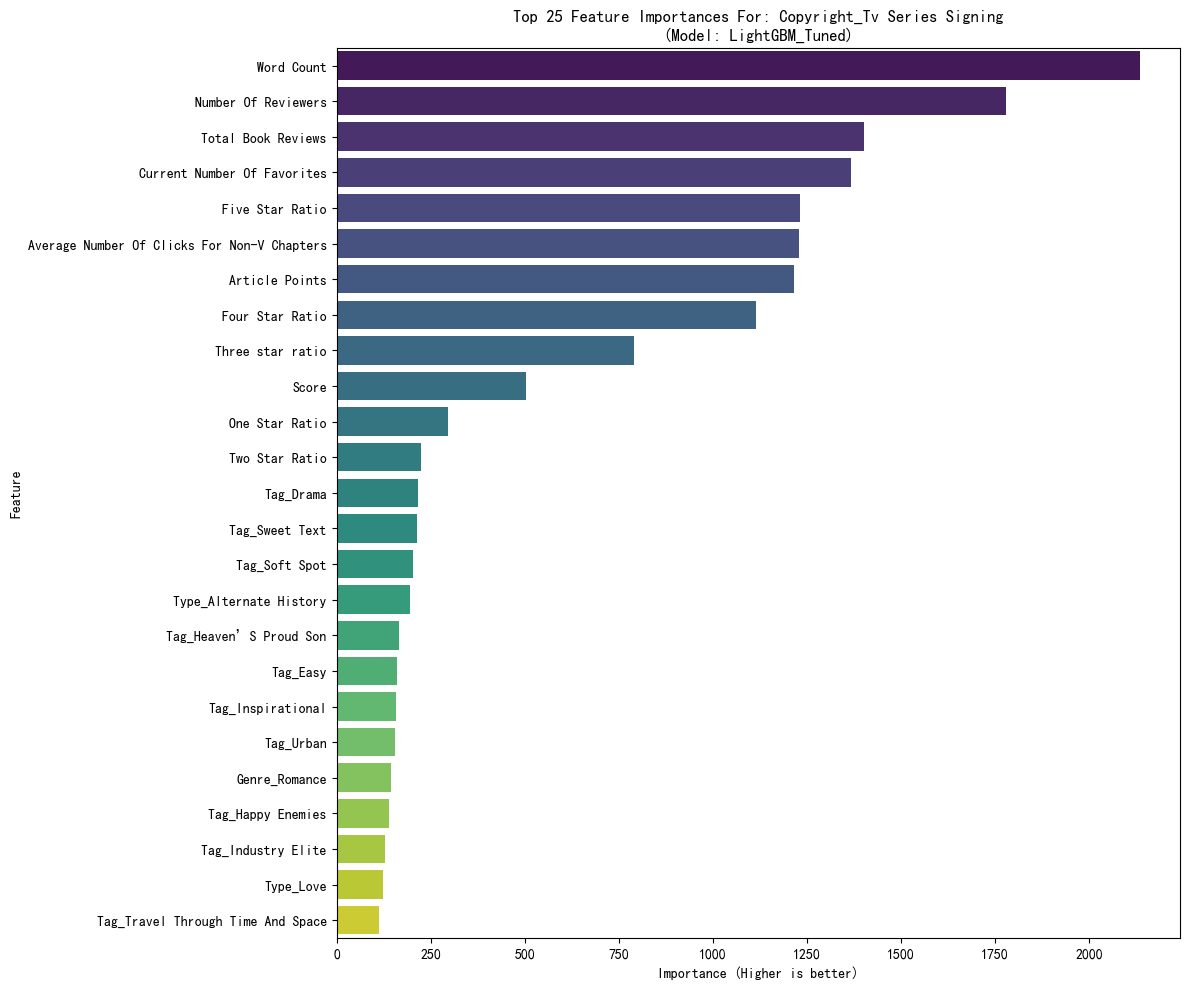

Analyzing Importances for Target: 版权_广播剧签约
Using best parameters: {'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 60, 'n_estimators': 400, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Re-training final model for 版权_广播剧签约
[LightGBM] [Info] Number of positive: 1875, number of negative: 60128
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 62003, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030240 -> initscore=-3.467867
[LightGBM] [Info] Start training from score -3.467867

Top 25 Most Important Features for [版权_广播剧签约]
       Feature  Importance
0           字数        2386
1    非v章节章均点击数        1865
6         评价人数        1768
2         总书评数        1394
3       当前被收藏数        1351
4         文章积分        1323
8         四星比例        1247
7         五星比例      

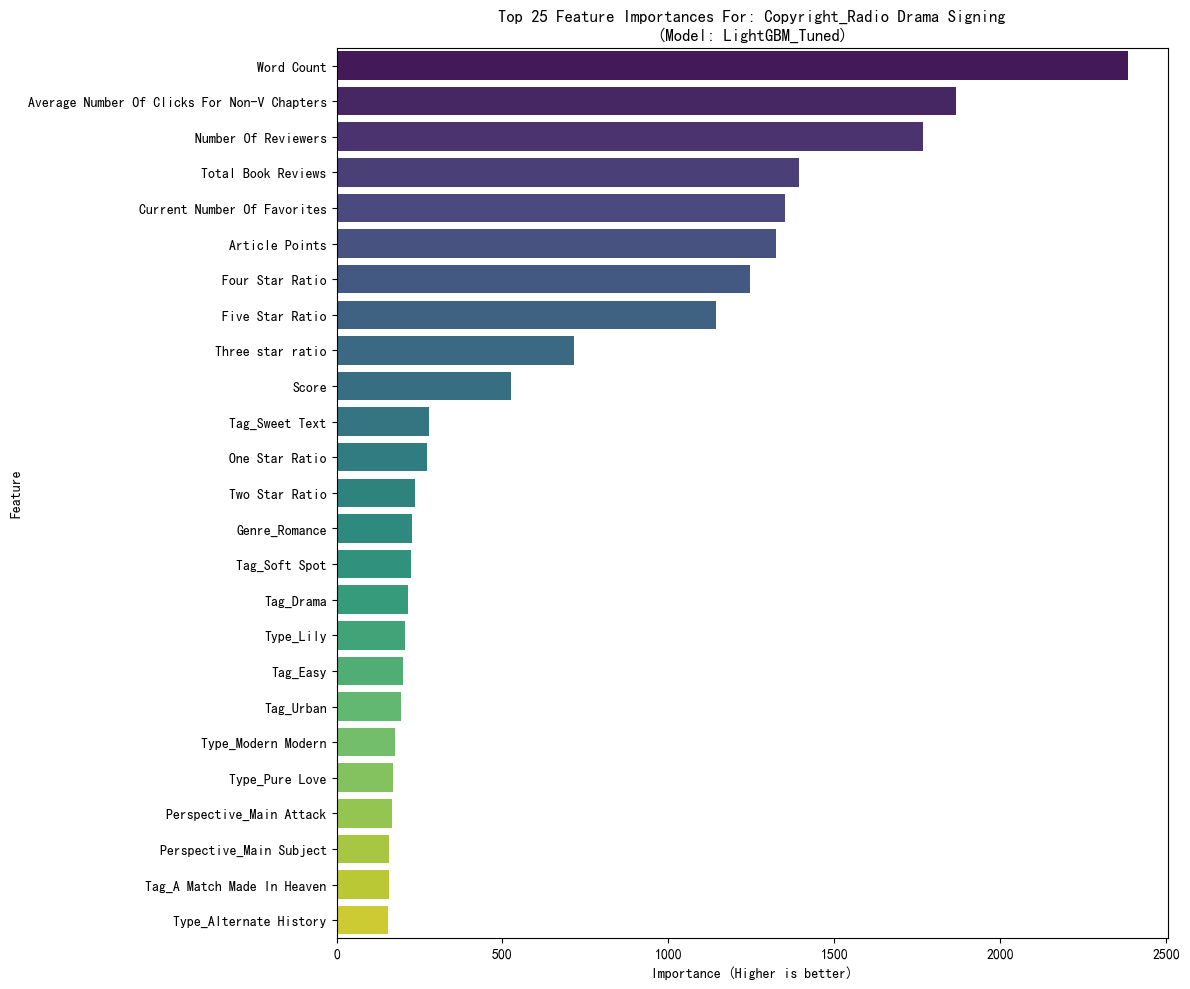

Analyzing Importances for Target: 版权_网络剧签约
Using best parameters: {'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 70, 'n_estimators': 400, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Re-training final model for 版权_网络剧签约
[LightGBM] [Info] Number of positive: 987, number of negative: 61016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 62003, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015919 -> initscore=-4.124221
[LightGBM] [Info] Start training from score -4.124221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

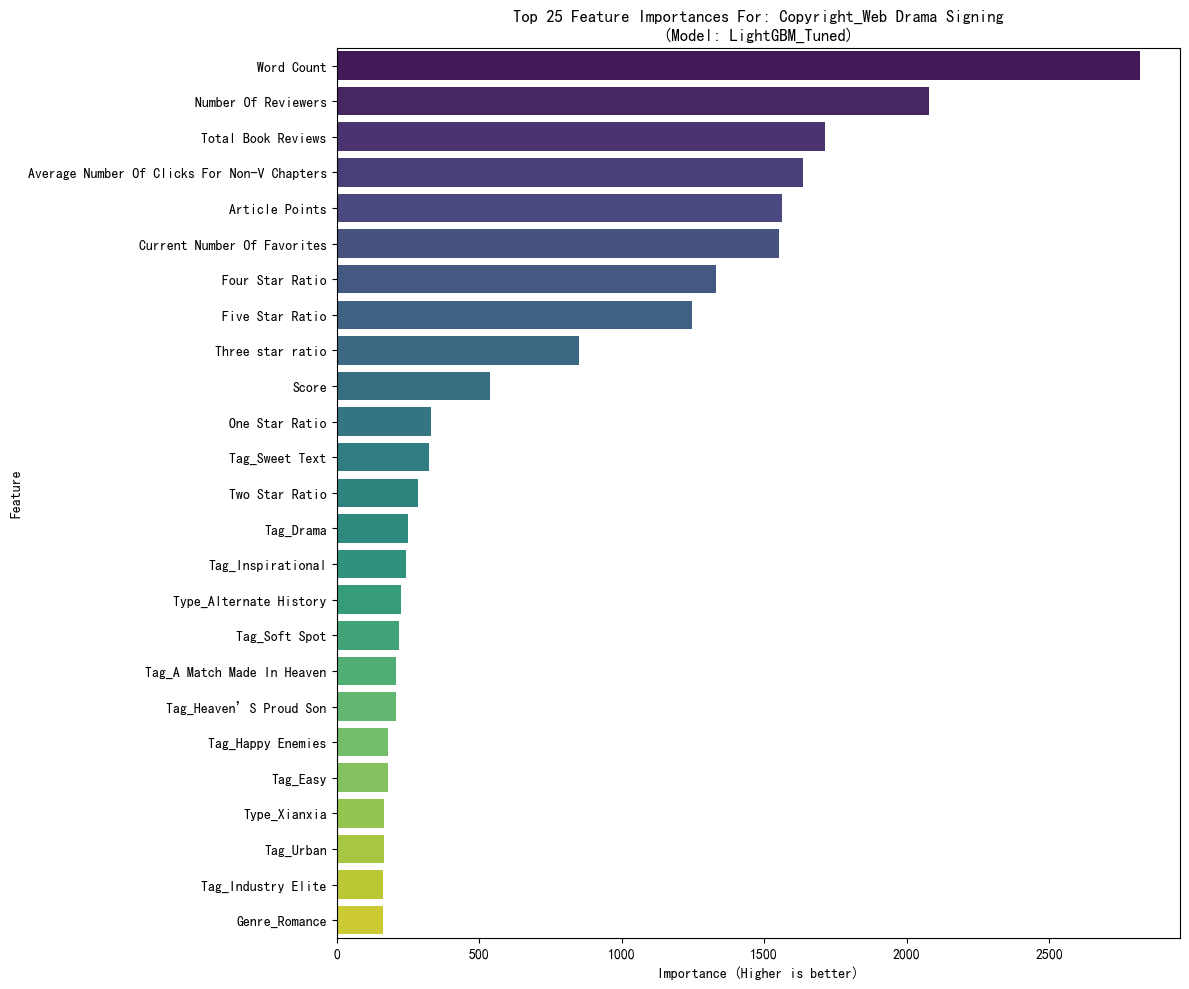

Analyzing Importances for Target: 版权_衍生品签约
Using best parameters: {'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 60, 'n_estimators': 400, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Re-training final model for 版权_衍生品签约
[LightGBM] [Info] Number of positive: 779, number of negative: 61224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 62003, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012564 -> initscore=-4.364284
[LightGBM] [Info] Start training from score -4.364284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

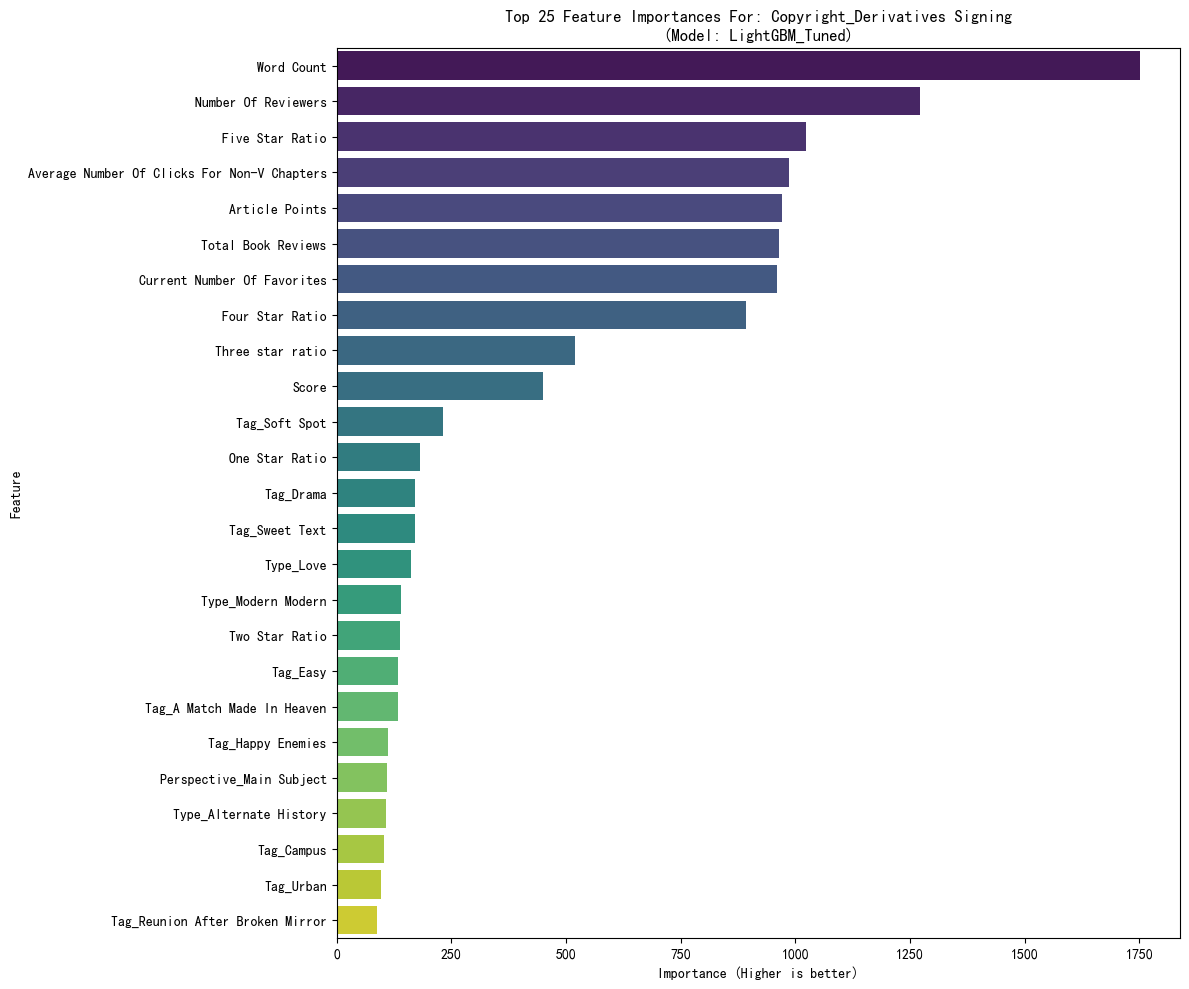

Analyzing Importances for Target: 版权_有声读物签约
Using best parameters: {'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 60, 'n_estimators': 400, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Re-training final model for 版权_有声读物签约
[LightGBM] [Info] Number of positive: 1088, number of negative: 60915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 62003, number of used features: 244
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017548 -> initscore=-4.025138
[LightGBM] [Info] Start training from score -4.025138

Top 25 Most Important Features for [版权_有声读物签约]
       Feature  Importance
0           字数        2256
1    非v章节章均点击数        1933
6         评价人数        1845
3       当前被收藏数        1567
2         总书评数        1525
8      

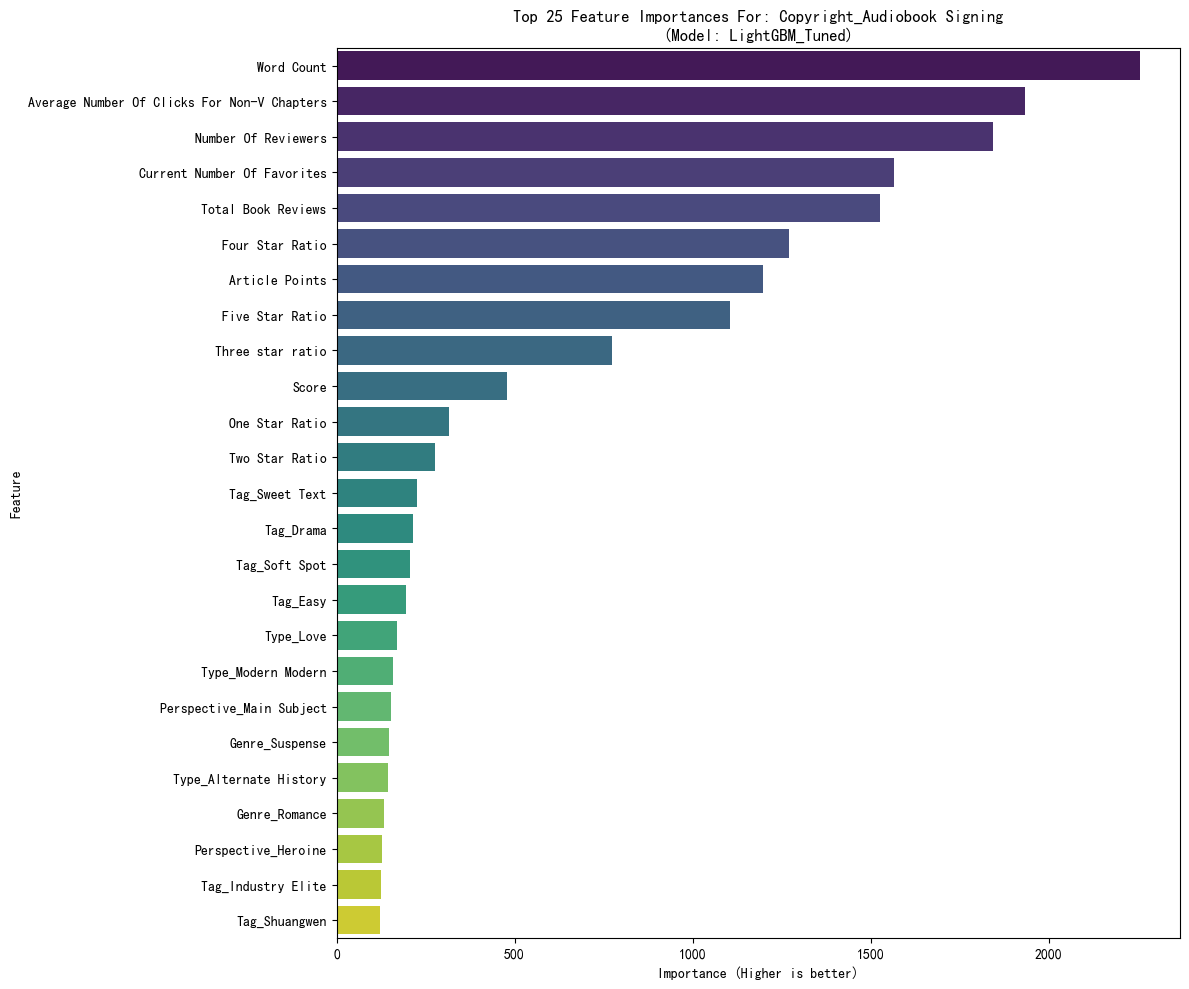

Analyzing RF Importances for Target: 版权_电视剧签约
Using best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Saved plot to: feature_importance_plots\RF_Importance_版权_电视剧签约.png


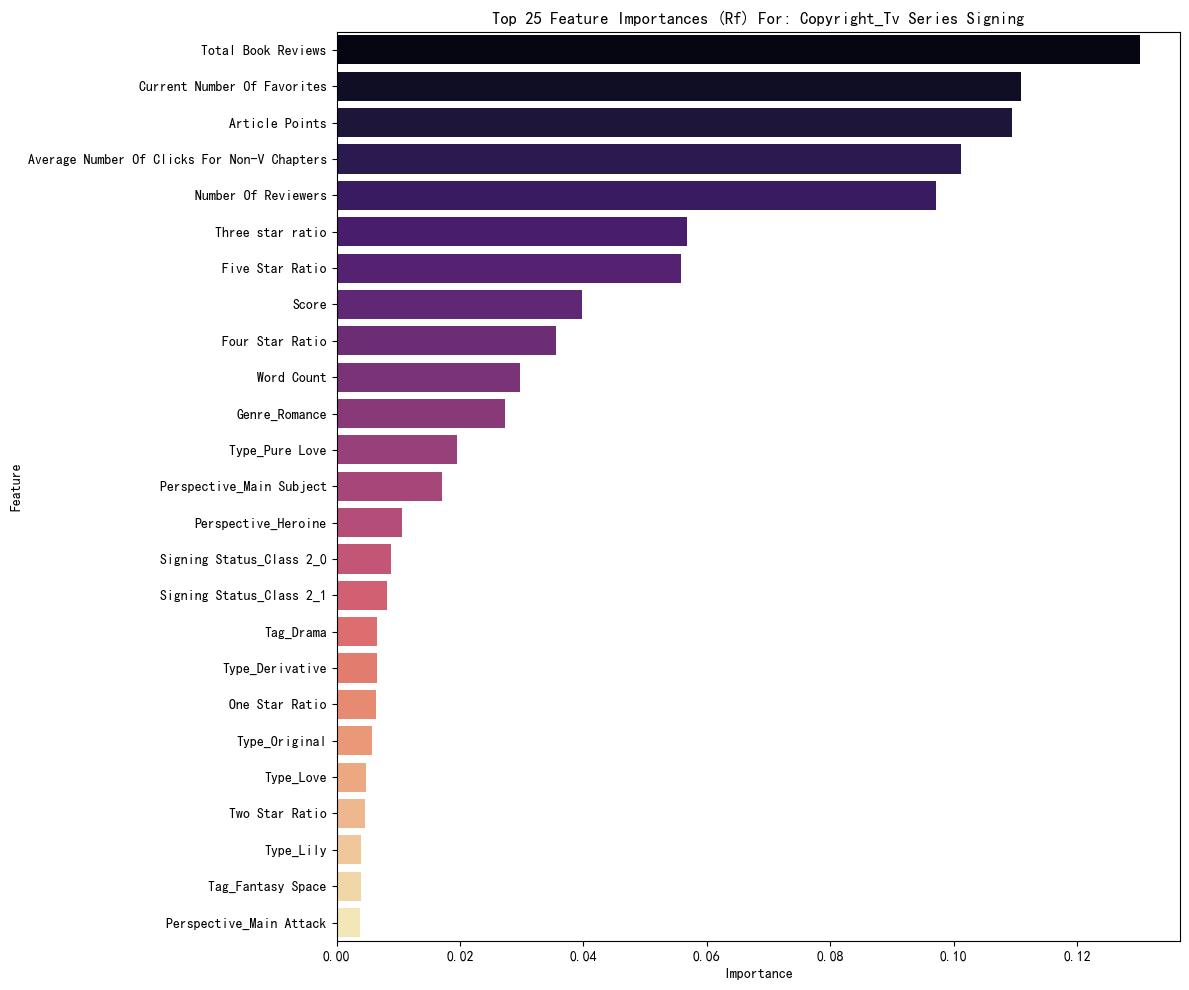

Analyzing RF Importances for Target: 版权_广播剧签约
Using best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Saved plot to: feature_importance_plots\RF_Importance_版权_广播剧签约.png


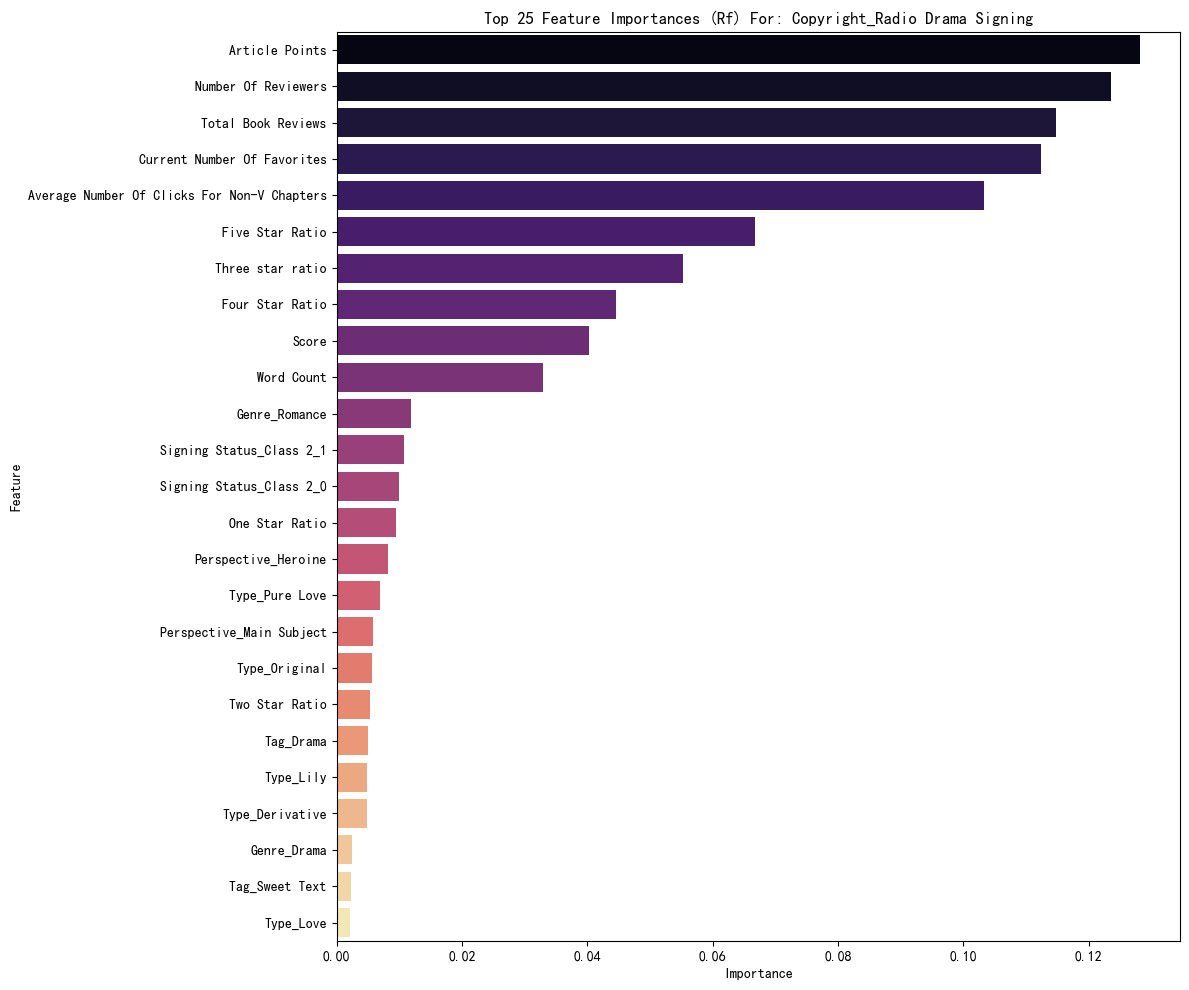

Analyzing RF Importances for Target: 版权_网络剧签约
Using best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Saved plot to: feature_importance_plots\RF_Importance_版权_网络剧签约.png


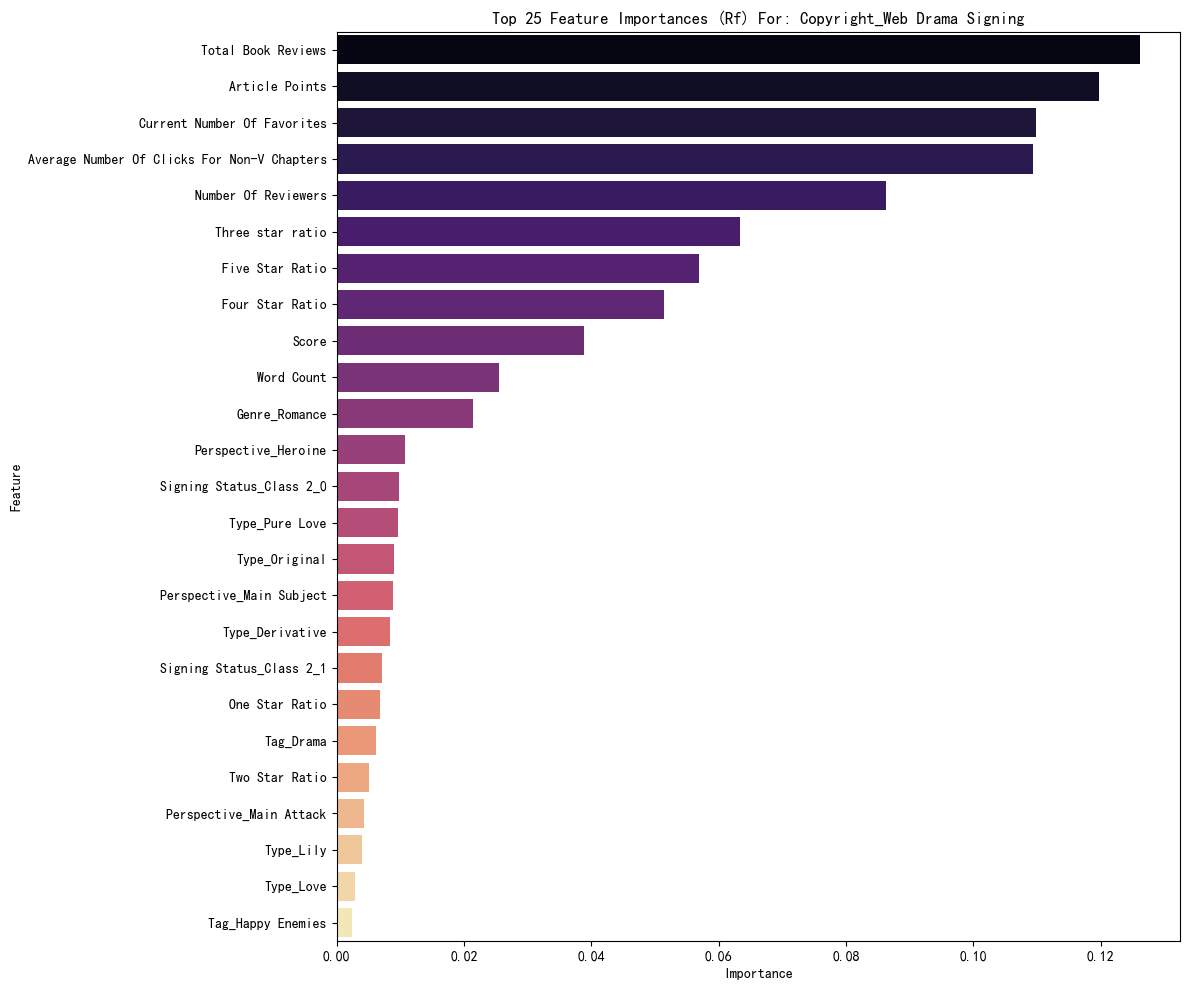

Analyzing RF Importances for Target: 版权_衍生品签约
Using best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Saved plot to: feature_importance_plots\RF_Importance_版权_衍生品签约.png


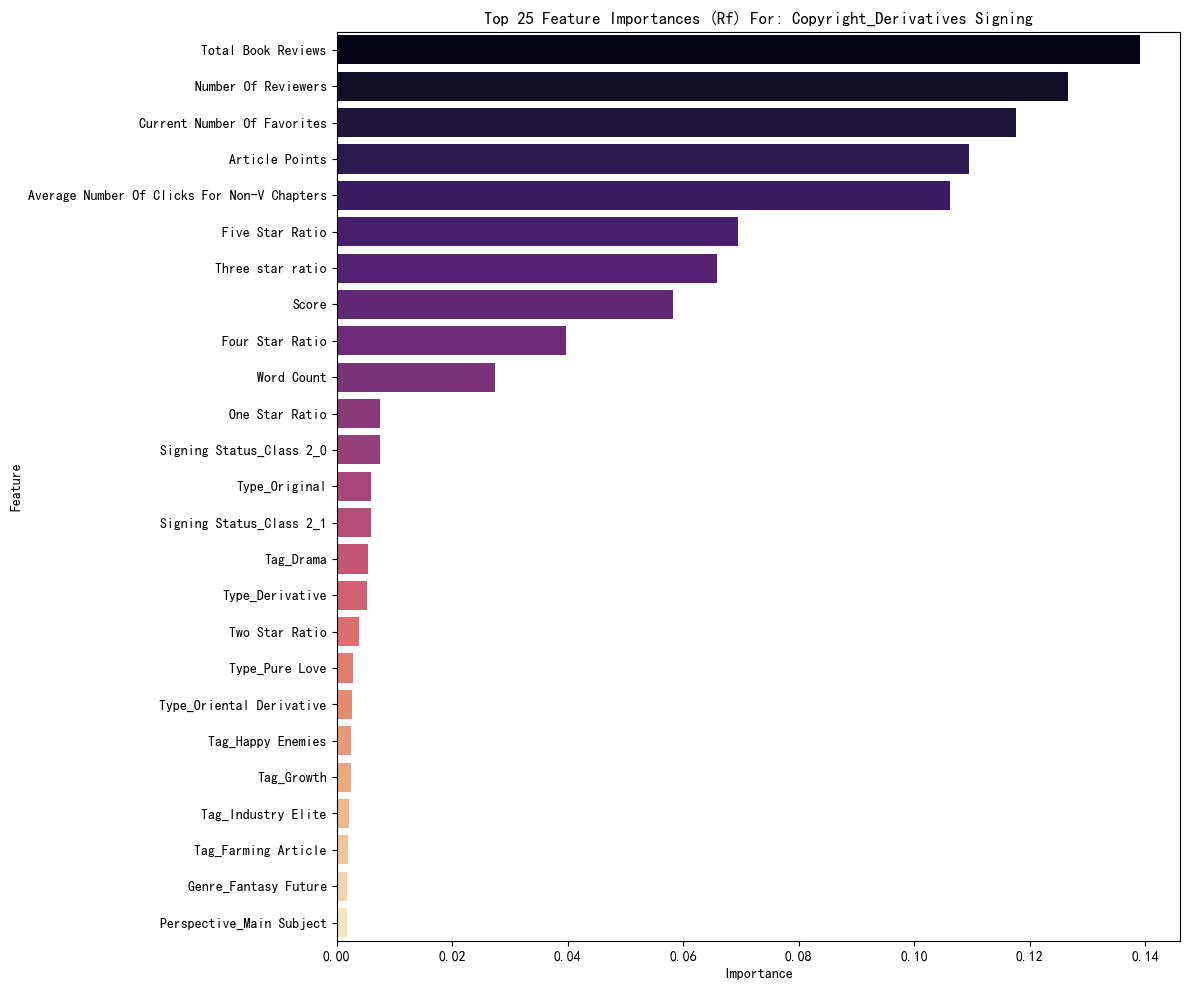

Analyzing RF Importances for Target: 版权_有声读物签约
Using best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Saved plot to: feature_importance_plots\RF_Importance_版权_有声读物签约.png


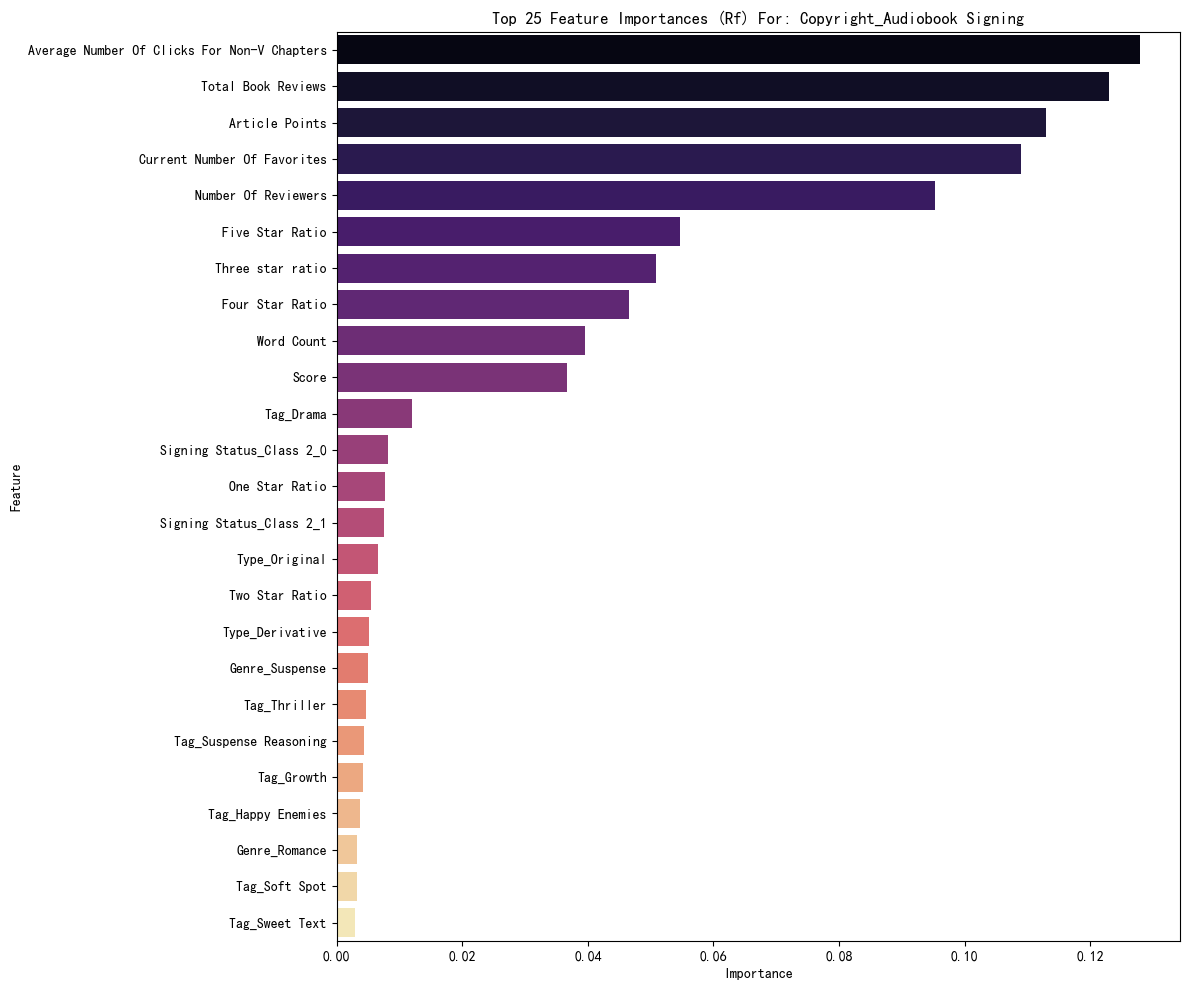

                                         Feature  Importance
8                                Four Star Ratio    0.068074
5                                          Score    0.056792
0                                     Word Count    0.054690
2                             Total Book Reviews    0.052385
7                                Five Star Ratio    0.050518
4                                 Article Points    0.043260
9                               Three star ratio    0.042257
31                                Type_Pure Love    0.040005
1    Average Number Of Clicks For Non-V Chapters    0.035824
182                                Tag_Shuangwen    0.035100
34                                 Genre_Romance    0.034638
47                           Perspective_Heroine    0.032979
11                                One Star Ratio    0.030379
6                            Number Of Reviewers    0.029088
3                    Current Number Of Favorites    0.027127
201            Tag_Trave

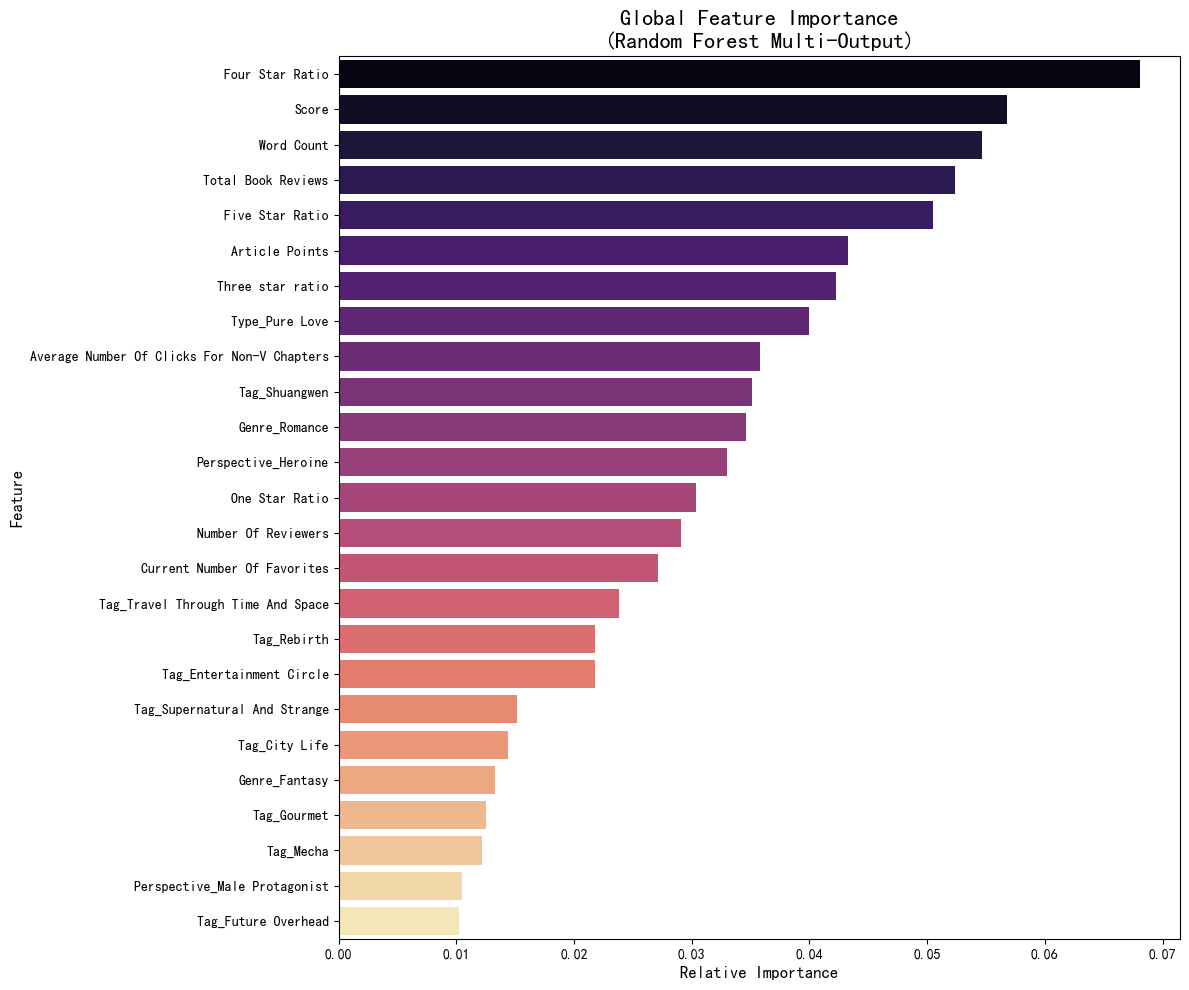

In [ ]:
#Feature Importance Analysis
MODEL_TO_ANALYZE = 'LightGBM_Tuned'

PLOT_OUTPUT_DIR = "feature_importance_plots"
if not os.path.exists(PLOT_OUTPUT_DIR):
    os.makedirs(PLOT_OUTPUT_DIR)
    print(f"Created directory to save plots: {PLOT_OUTPUT_DIR}")


feature_names = preprocessor.get_feature_names_out()
feature_names = [name.split('__')[-1] for name in feature_names]
print(f"retrieved {len(feature_names)} feature names from preprocessor.")


for target in target_cols:
    
    print(f"Analyzing Importances for Target: {target}")
 
    if target not in all_model_results or MODEL_TO_ANALYZE not in all_model_results[target]:
        print(f"Skipping {target}: No valid results found for {MODEL_TO_ANALYZE}.")
        continue

    best_params = all_model_results[target][MODEL_TO_ANALYZE]['Best_Params']
    print(f"Using best parameters: {best_params}")

    y_train_single = Y_train[target]
    count_pos = y_train_single.sum()
    
    if count_pos == 0:
        print(f"Skipping {target}: No positive samples in training data.")
        continue
        
    pos_weight = (y_train_single == 0).sum() / count_pos
    
 
    final_model = LGBMClassifier(
        device='cpu',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=pos_weight,
        **best_params 
    )
    
    print(f"Re-training final model for {target}")
    final_model.fit(X_train_processed, y_train_single)
    

    importances = final_model.feature_importances_
    
   
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    importance_df_en = translate_dataframe(importance_df.head(25))
    print(f"\nTop 25 Most Important Features for [{target}]")
    print(importance_df.head(25))
    
    fig = plt.figure(figsize=(12, 10))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=importance_df_en.head(25),
        palette='viridis'
    )
    title_text = translate_if_chinese(f"Top 25 Feature Importances for: {target}")
    plt.title(f"{title_text}\n(Model: LightGBM_Tuned)")
    plt.xlabel("Importance (Higher is better)")
    plt.ylabel("Feature")
    plt.tight_layout()
    

    safe_filename = f"LGBM_Importance_{target}.png"
    save_path = os.path.join(PLOT_OUTPUT_DIR, safe_filename)
    

    plt.savefig(save_path, dpi=150)
    print(f"save plot to: {save_path}")


    
    plt.show() 
    plt.close(fig) 
#Feature Importance for RandomForest
MODEL_TO_ANALYZE_RF = 'RandomForest_Tuned'

for target in target_cols:
    print(f"Analyzing RF Importances for Target: {target}")

    if target not in all_model_results or MODEL_TO_ANALYZE_RF not in all_model_results[target]:
        print(f"Skipping {target}: No valid results found for {MODEL_TO_ANALYZE_RF}.")
        continue

    best_params = all_model_results[target][MODEL_TO_ANALYZE_RF]['Best_Params']
    print(f"Using best parameters: {best_params}")

    y_train_single = Y_train[target]

    final_rf_single = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight='balanced_subsample',
        **best_params
    )

    final_rf_single.fit(X_train_processed, y_train_single)

    importances = final_rf_single.feature_importances_

    rf_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    rf_imp_df = rf_imp_df.sort_values(by='Importance', ascending=False)
    rf_imp_df_en = translate_dataframe(rf_imp_df.head(25))

    fig = plt.figure(figsize=(12, 10))
    sns.barplot(
        x='Importance',
        y='Feature',
        data=rf_imp_df_en.head(25),
        palette='magma'
    )
    title_text = translate_if_chinese(f"Top 25 Feature Importances (RF) for: {target}")
    plt.title(f"{title_text}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()

    safe_filename = f"RF_Importance_{target}.png"
    save_path = os.path.join(PLOT_OUTPUT_DIR, safe_filename)

    plt.savefig(save_path, dpi=150)
    print(f"Saved plot to: {save_path}")

    plt.show()
    plt.close(fig)
if 'best_rf_multi' not in locals():
    print("Error: 'best_rf_multi' not found.")
else:
    winner_model = best_rf_multi


    try:
        feature_names = preprocessor.get_feature_names_out()

        feature_names = [name.split('__')[-1] for name in feature_names]
    except:
        feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

    importances = winner_model.feature_importances_

    rf_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)
    rf_importance_df_en = translate_dataframe(rf_importance_df.head(25))
    print(rf_importance_df_en.head(25))


    plt.figure(figsize=(12, 10))
    sns.barplot(
        x='Importance',
        y='Feature',
        data=rf_importance_df_en.head(25),
        palette='magma' 
    )
    
    plt.title('Global Feature Importance\n(Random Forest Multi-Output)', fontsize=16)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()


    save_path = os.path.join(PLOT_OUTPUT_DIR, "Global_Feature_Importance_RF.png")
    plt.savefig(save_path, dpi=150)
    print(f"Saved plot to: {save_path}")
    
    plt.show()


Data prepared for plotting:
   index        F1     AUPRC                                                                                          Best_Params                         Target                     Model
0      7  0.365854  0.274329  {'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 60, 'n_estimators': 400, 'learning_rate': 0.1, '...  Copyright_Radio Drama Signing            LightGBM_Tuned
1      5  0.047983  0.153876                                                                                           {'C': 0.1}  Copyright_Radio Drama Signing           LinearSVC_Tuned
2      4  0.059663  0.197769                                                                                           {'C': 0.1}  Copyright_Radio Drama Signing  LogisticRegression_Tuned
3      6  0.285714  0.196408                                      {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}  Copyright_Radio Drama Signing        RandomForest_Tuned
4     19  0.333333  0.221636  {'reg_l

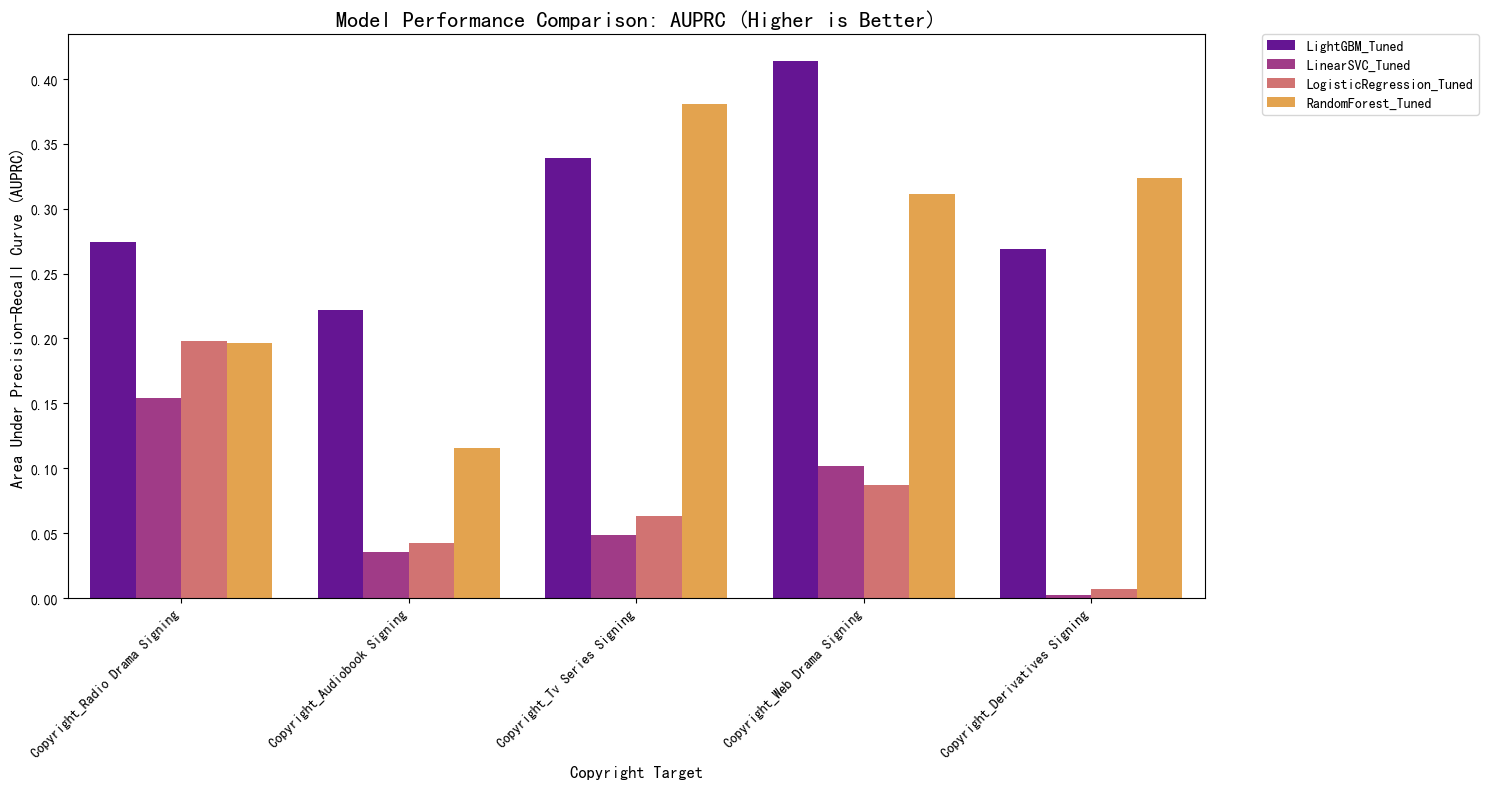


F1-Score Comparison Plot


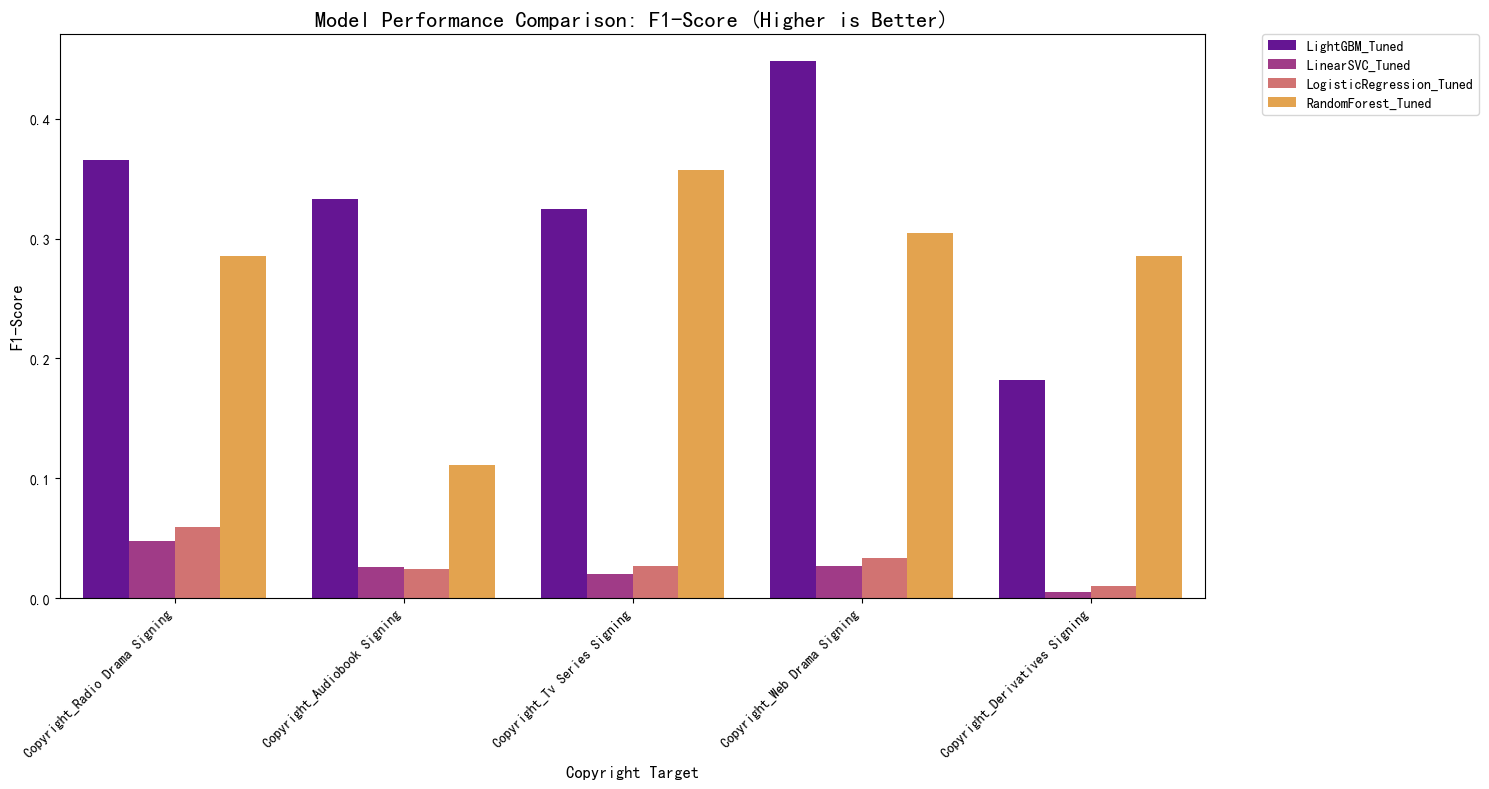


 All comparison plots saved.


In [ ]:
#Model Performance Visualization

if 'results_df' not in locals():
    print("Error: 'results_df' not found.")
else:

    plot_data = results_df.reset_index()
    plot_data.columns = [col[0] if isinstance(col, tuple) else col for col in plot_data.columns]
    plot_data_en = translate_dataframe(plot_data)
    print("Data prepared for plotting:")
    print(plot_data_en.head())


    print("\nGenerating AUPRC Comparison Plot")
    
    plt.figure(figsize=(15, 8))
    

    ax = sns.barplot(
        data=plot_data_en,
        x='Target',
        y='AUPRC',
        hue='Model',
        palette='plasma'
    )
    
    ax.set_title('Model Performance Comparison: AUPRC (Higher is Better)', fontsize=16)
    ax.set_ylabel('Area Under Precision-Recall Curve (AUPRC)', fontsize=12)
    ax.set_xlabel('Copyright Target', fontsize=12)
    

    plt.xticks(rotation=45, ha='right')
    

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout() 
    

    save_path_auprc = os.path.join(PLOT_OUTPUT_DIR, "Model_Comparison_AUPRC.png")
    plt.savefig(save_path_auprc, dpi=150, bbox_inches='tight') 


    plt.show()


    print("\nF1-Score Comparison Plot")
    
    plt.figure(figsize=(15, 8))
    
    ax = sns.barplot(
        data=plot_data_en,
        x='Target',
        y='F1',
        hue='Model',
        palette='plasma'
    )
    
    ax.set_title('Model Performance Comparison: F1-Score (Higher is Better)', fontsize=16)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_xlabel('Copyright Target', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    

    save_path_f1 = os.path.join(PLOT_OUTPUT_DIR, "Model_Comparison_F1.png")

    plt.savefig(save_path_f1, dpi=150, bbox_inches='tight')
    
    plt.show()

print("\n All comparison plots saved.")


Multi-Output (MO) data prepared for plotting:
                            Model  F1 (Micro)  F1 (Macro)
0  RandomForest_MultiOutput_Tuned    0.257576    0.249062
1      ClassifierChain_LGBM_Tuned    0.387097    0.376911

Data after 'melting' for plotting:
                            Model Metric_Type  F1_Score
0  RandomForest_MultiOutput_Tuned  F1 (Micro)  0.257576
1      ClassifierChain_LGBM_Tuned  F1 (Micro)  0.387097
2  RandomForest_MultiOutput_Tuned  F1 (Macro)  0.249062
3      ClassifierChain_LGBM_Tuned  F1 (Macro)  0.376911


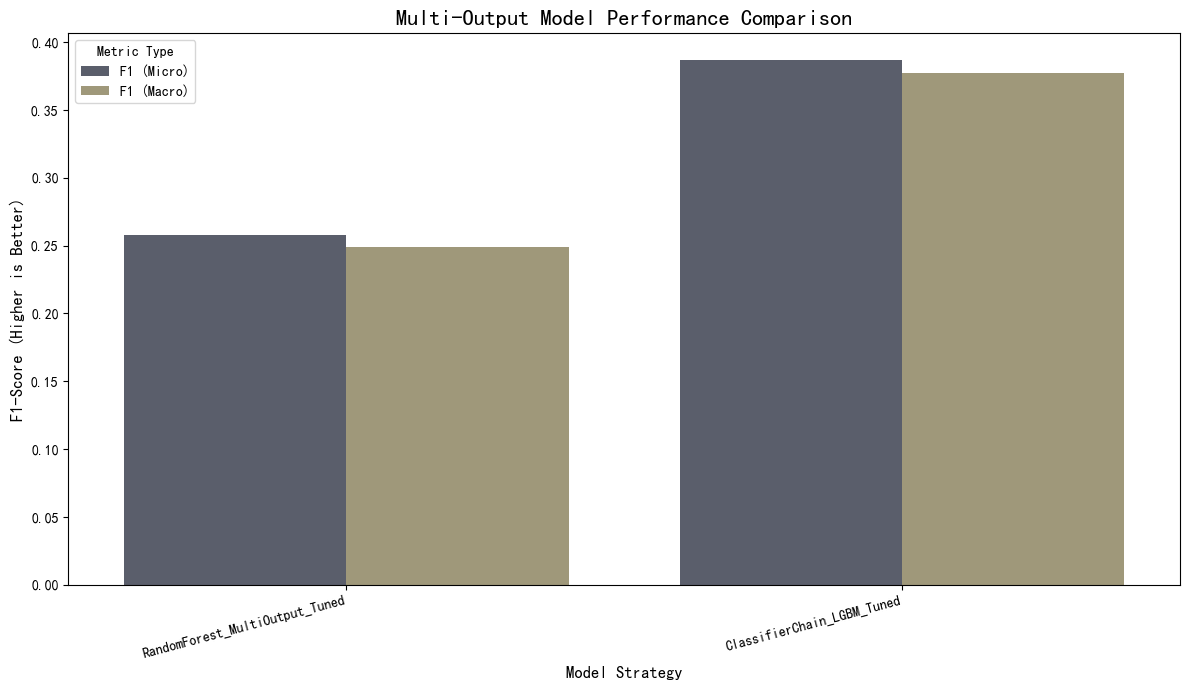


Multi-Output comparison plots saved.


In [ ]:
#Multi-Output (MO) Model Performance Visualization


if 'mo_results_df' not in locals() or mo_results_df.empty:
    print("Error: 'mo_results_df' not found or is empty.")
else:
    print("Multi-Output (MO) data prepared for plotting:")
    print(mo_results_df[['Model', 'F1 (Micro)', 'F1 (Macro)']])


    plot_data_mo = pd.melt(
        mo_results_df, 
        id_vars=['Model'], 
        value_vars=['F1 (Micro)', 'F1 (Macro)'], 
        var_name='Metric_Type', 
        value_name='F1_Score' 
    )
    
    print("\nData after 'melting' for plotting:")
    print(plot_data_mo)
    
    plt.figure(figsize=(12, 7))
    
    ax = sns.barplot(
        data=plot_data_mo,
        x='Model',      
        y='F1_Score',     
        hue='Metric_Type',
        palette='cividis' 
    )
    
    ax.set_title('Multi-Output Model Performance Comparison', fontsize=16)
    ax.set_ylabel('F1-Score (Higher is Better)', fontsize=12)
    ax.set_xlabel('Model Strategy', fontsize=12)
    

    plt.xticks(rotation=15, ha='right')
    
    plt.legend(title='Metric Type')
    plt.tight_layout()
    

    save_path_mo = os.path.join(PLOT_OUTPUT_DIR, "Model_Comparison_MultiOutput.png")

    plt.savefig(save_path_mo, dpi=150, bbox_inches='tight')
     
    plt.show()

print("\nMulti-Output comparison plots saved.")

Per-Label Data Prepared:
                            Model     Target  F1_Score
0  RandomForest_MultiOutput_Tuned   版权_电视剧签约  0.285714
1  RandomForest_MultiOutput_Tuned   版权_广播剧签约  0.333333
2  RandomForest_MultiOutput_Tuned   版权_网络剧签约  0.181818
3  RandomForest_MultiOutput_Tuned   版权_衍生品签约  0.333333
4  RandomForest_MultiOutput_Tuned  版权_有声读物签约  0.111111

Heatmap
save Heatmap to: feature_importance_plots\Model_Comparison_Per_Label_Heatmap.png


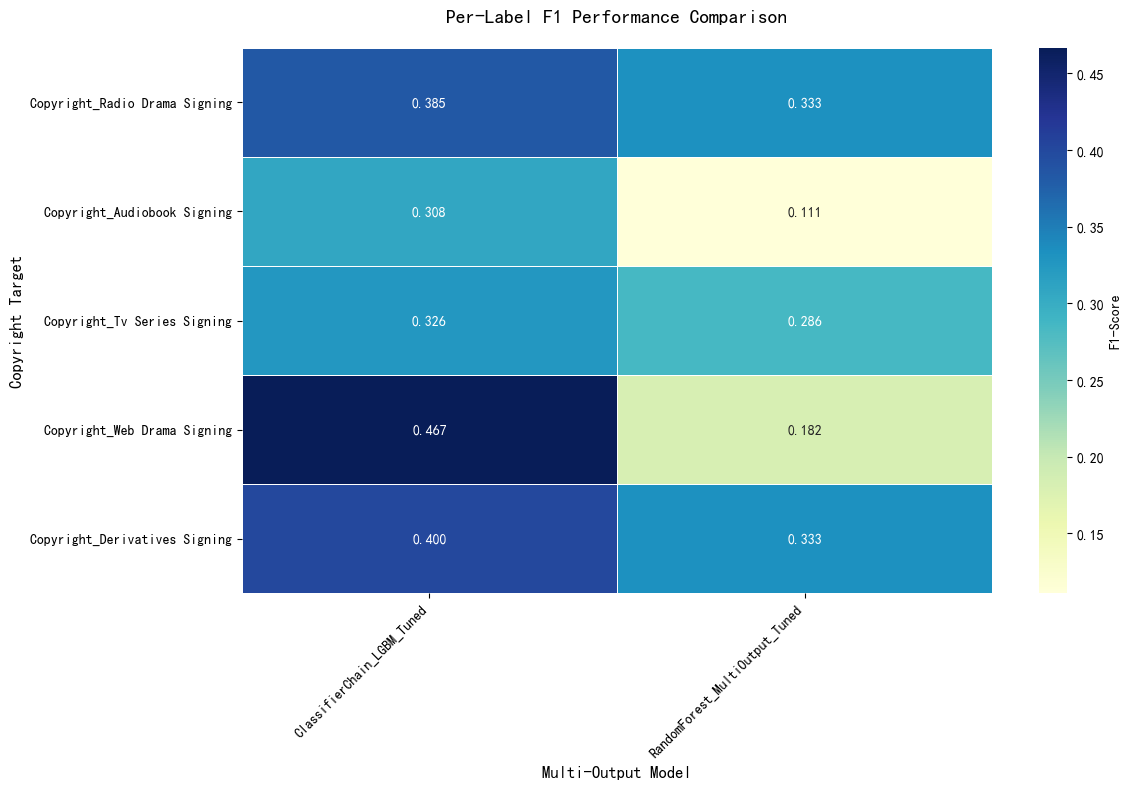

In [ ]:
#Per-Label Performance Analysis for multi output models

per_label_data = []

for model_name, results in all_model_results.items():
    if model_name.endswith('_Tuned') and 'F1_Per_Label' in results:
        
        f1_series = results['F1_Per_Label']

        for label_name, score in f1_series.items():
            per_label_data.append({
                'Model': model_name,
                'Target': label_name,
                'F1_Score': score
            })

if not per_label_data:
    print("Error: No 'F1_Per_Label' data found.")
else:

    df_per_label = pd.DataFrame(per_label_data)
    
    print("Per-Label Data Prepared:")
    print(df_per_label.head())

    heatmap_data = df_per_label.pivot(index='Target', columns='Model', values='F1_Score')
    heatmap_data = heatmap_data.sort_index()
    heatmap_data_en = translate_dataframe(heatmap_data)

    print("\nHeatmap")

    plt.figure(figsize=(12, 8))
    
    sns.heatmap(
        heatmap_data_en,
        annot=True, 
        fmt='.3f', 
        cmap='YlGnBu', 
        linewidths=.5,
        cbar_kws={'label': 'F1-Score'}
    )
    
    plt.title('Per-Label F1 Performance Comparison\n', fontsize=14)
    plt.ylabel('Copyright Target', fontsize=12)
    plt.xlabel('Multi-Output Model', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    save_path_heatmap = os.path.join(PLOT_OUTPUT_DIR, "Model_Comparison_Per_Label_Heatmap.png")
    plt.savefig(save_path_heatmap, dpi=150, bbox_inches='tight')
    print(f"save Heatmap to: {save_path_heatmap}")
        
    plt.show()